In [97]:
import numpy as np
from catboost import Pool, CatBoostRegressor
import seaborn as sns
import matplotlib.pyplot as plt

In [95]:
# function for generating mean and variance
def gen_parameters(num_cat=9, noise=0.1):
    mean = np.random.rand(num_cat, num_cat)

    var = np.zeros([num_cat, num_cat])
    for i in range(num_cat):
        for j in range(num_cat):
            var[i,j] = noise

    pixels_border = [[1,2], [1,6], [2,1], [2,3], [2,5], [2,7], [3,0], [3,4], [3,8], [4,1], [4,7], [5,2], [5,6], [6,3], [6,5], [7,4]]
    pixels_inside = [[2,2], [2,6], [3,1], [3,2], [3,3], [3,5], [3,6], [3,7], [4,2], [4,3], [4,4], [4,5], [4,6], [5,3], [5,4], [5,5], [6,4]]
    
    for pixel in pixels_border:
        var[pixel[0],pixel[1]] = 2*noise
        
    for pixel in pixels_inside:
        var[pixel[0],pixel[1]] = 0
    return mean, var

True data uncertainty (variance):


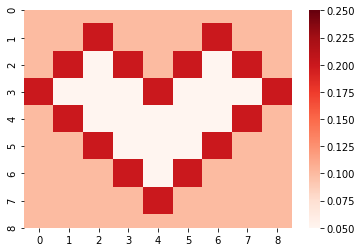

In [98]:
# generate parameters and plot variance:
mean, var = gen_parameters()
print("True data uncertainty (variance):")
sns.heatmap(var, cmap="Reds", vmin = 0.05, vmax = 0.25)
plt.show()

In [55]:
# function for generating train and validation sets
def generate_training_data(n_samples, mean, var, num_cat=9):
    train = []
    target = []
    val = []
    val_target = []
    pixels = [[2,2], [2,6], [3,1], [3,2], [3,3], [3,5], [3,6], [3,7], [4,2], [4,3], [4,4], [4,5], [4,6], [5,3], [5,4], [5,5], [6,4]]
    for i in range(num_cat):
        for j in range(num_cat):
            if [i,j] in pixels:
                continue
            for _ in range(n_samples):
                train.append([i,j])
                val.append([i,j])
                target.append(np.random.normal(mean[i,j], var[i,j]))
                val_target.append(np.random.normal(mean[i,j], var[i,j]))
    train = np.asarray(train)
    target = np.asarray(target)

    return train, target, val, val_target

In [75]:
# generate train and validation datasets
train, target, val, val_target = generate_training_data(1000, mean, var)

train_pool = Pool(train, target, cat_features = [0, 1])
val_pool = Pool(val, val_target, cat_features = [0, 1])

# generate test, consisting of all possible feature combinations
num_cat = 9
test = []
for i in range(num_cat):
    for j in range(num_cat):
        test.append([i,j])
test = np.asarray(test)

best iteration = 984
Predicted data uncertainty:


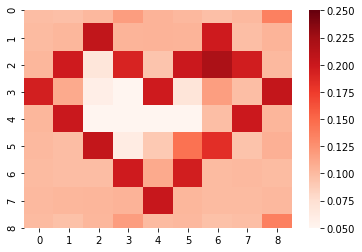

In [76]:
# predict data uncertainty

model = CatBoostRegressor(iterations=1000, learning_rate=0.2,
                          loss_function='RMSEWithUncertainty', verbose = False)
model.fit(train_pool, eval_set=val_pool)
print("best iteration =", model.get_best_iteration())
preds = model.predict(test)

mean_preds = preds[:,0]
var_preds = preds[:,1]

print("Predicted data uncertainty:")

sns.heatmap(var_preds.reshape([num_cat,num_cat]), cmap="Reds", vmin = 0.05, vmax = 0.25)
plt.show()

In [104]:
def ensemble(train_pool, val_pool, num_samples=10, iters=1000, lr = 0.2):
    ens_preds = []
    for seed in range(num_samples):
        model = CatBoostRegressor(random_seed = seed, iterations=iters, learning_rate=lr, 
                                 loss_function='RMSEWithUncertainty', posterior_sampling=True,
                                 verbose=False)
        model.fit(train_pool, eval_set=val_pool)
        ens_preds.append(model.predict(test))
    return ens_preds

Knowledge uncertainty via ensemble:


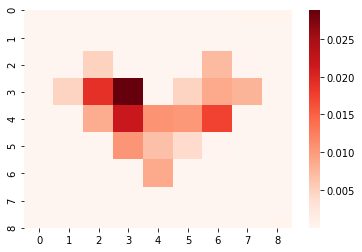

In [105]:
ens_preds = ensemble(train_pool, val_pool, num_samples=10, iters=1000, lr=0.2)
ens_preds = np.asarray(ens_preds)
knowledge = np.var(ens_preds, axis = 0)[:,0]

print("Knowledge uncertainty via ensemble:")            
sns.heatmap(knowledge.reshape([num_cat,num_cat]), cmap="Reds")
plt.show()

In [100]:
def virt_ensemble(train_pool, val_pool, num_samples=10, iters=1000, lr=0.2):
    ens_preds = []
    model = CatBoostRegressor(iterations=iters, learning_rate=lr, loss_function='RMSEWithUncertainty', 
                              posterior_sampling=True, verbose=False)
    model.fit(train_pool, eval_set=val_pool)
    ens_preds = model.virtual_ensembles_predict(test, prediction_type='VirtEnsembles', virtual_ensembles_count=num_samples)
    return ens_preds

Knowledge uncertainty, virtual


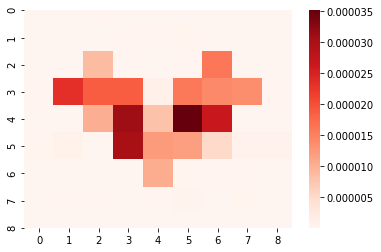

In [101]:
# we can deal with virtual ensemble similarty

ens_preds = virt_ensemble(train_pool, val_pool, num_samples=10, iters=1000, lr = 0.2)

ens_preds = np.asarray(ens_preds)
ens_preds = ens_preds.reshape((81, 10, 2))

knowledge = np.var(ens_preds, axis = 1)[:,0]

print("Knowledge uncertainty, virtual")
sns.heatmap(knowledge.reshape([num_cat,num_cat]), cmap="Reds")
plt.show()

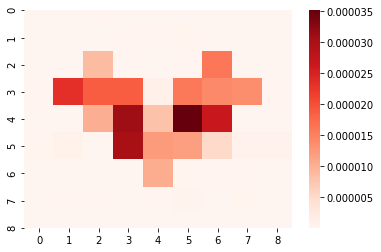

In [99]:
# Use prediction_type='TotalUncertainty' and get the same result easier

model = CatBoostRegressor(iterations=1000, learning_rate=0.2, loss_function='RMSEWithUncertainty', 
                          posterior_sampling=True, verbose=False)
model.fit(train_pool, eval_set=val_pool)
preds = model.virtual_ensembles_predict(test, prediction_type='TotalUncertainty', virtual_ensembles_count=10)
knowledge = preds[:,1]

sns.heatmap(knowledge.reshape([num_cat,num_cat]), cmap="Reds")
plt.show()